In [6]:
import math

# =======================
# MICROGRAD ENGINE
# =======================
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        t = math.tanh(self.data)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t*t) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build(child)
                topo.append(v)

        build(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


# =======================
# YOUR NEURON EXAMPLE
# =======================

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.881375870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

s = x1w1 + x2w2; s.label = 'x1w1 + x2w2'

n = s + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o


Value(data=0.7071079227726491, grad=0.0)

In [7]:
from sklearn.datasets import load_iris
data = load_iris()
X = data ["data"]
y = data["target"]

X[:10]


array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

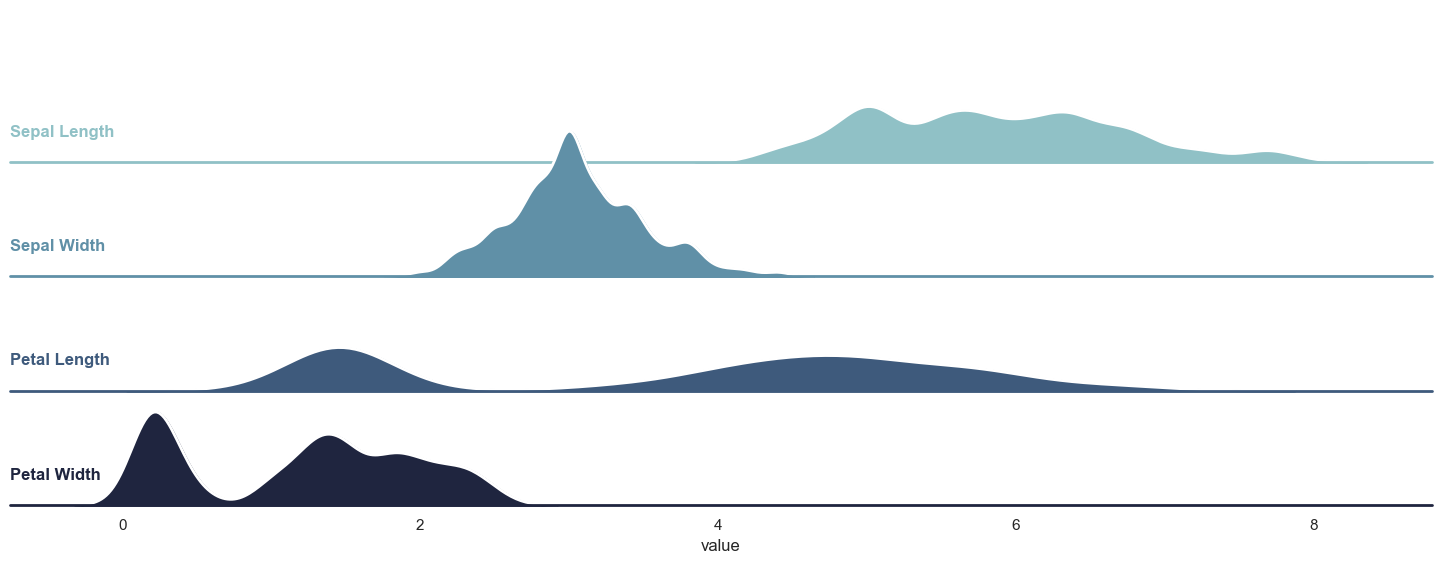

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the iris dataset
iris = sns.load_dataset("iris")

# Set style
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Melt the dataset to long format
df = iris.melt(id_vars='species', 
               value_vars=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
               var_name='measurement',
               value_name='value')

# Rename for nicer labels
df['measurement'] = df['measurement'].str.replace('_', ' ').str.title()

# Create a categorical order for nice plotting
order = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
df['measurement'] = pd.Categorical(df['measurement'], categories=order, ordered=True)
df = df.sort_values('measurement')

# Palette
pal = sns.cubehelix_palette(len(order), rot=-.25, light=.7)

# FacetGrid
g = sns.FacetGrid(df, row="measurement", hue="measurement", 
                  aspect=10, height=1.5, palette=pal)

# Filled KDE
g.map(sns.kdeplot, "value", bw_adjust=0.5, clip_on=False, 
      fill=True, alpha=1, linewidth=1.5)

# Outline KDE
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=0.5)

# Horizontal line at y=0
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Add labels
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "value")

# Adjust layout and styling
g.figure.subplots_adjust(hspace=-0.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.show()